In [824]:
from seqdata import getset
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import numpy
from numpy import argmax, vstack
import random
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear,ReLU, LeakyReLU,ELU,Softmax,Module,CrossEntropyLoss
from torch.optim import SGD,Adam
from torch.nn.init import kaiming_uniform_,xavier_uniform_, uniform_, ones_, zeros_, eye_
from torch.nn.parameter import Parameter



In [825]:
def xsample(x0,size):
    res=[]
    while size-len(res)>=len(x0):
        res.extend(x0)
    res.extend(random.sample(x0,size-len(res)))
    return res

def prepare_data(cats, cat_size=1000, batch_size=10):
    X,y=getset(7)
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1234567, shuffle=True)
    
    u,c=numpy.unique(y_train, return_counts=True)
    print(f"Counts for minimal group: {numpy.min(c)}")
    print(f"Counts for maximal group: {numpy.max(c)}")
    
    joined=[(x,lab) for x,lab in zip(X_train,y_train) if lab in cats]
    X_train=[x for x,lab in joined]
    y_train=[lab for x,lab in joined]
    
    
    joined=[(x,lab) for x,lab in zip(X_test,y_test) if lab in cats]
    X_test=[x for x,lab in joined]
    y_test=[lab for x,lab in joined]
    
    
    test=[[numpy.array(x,dtype=numpy.float32),y] for x,y in zip(X_test,numpy.array(y_test,dtype=numpy.int64))]    
    if cat_size>0:
        train=[]    
        #resample X_train and y_train
        random.seed(None) #1234567)
        new_X,new_y=[],[]
        for cat in cats:
            cat_xy=[(x,lab) for x,lab in zip(X_train,y_train) if lab==cat]
            qs=xsample(cat_xy, cat_size)
            #qs=[random.choice(cat_xy) for ii in range(cat_size)]
            qs=[[numpy.array(x,dtype=numpy.float32),numpy.array(lab,dtype=numpy.int64)] for x,lab in qs]
            train.extend(qs)
    else:
        train=[[numpy.array(x, dtype=numpy.float32),y] for x,y in zip(X_train,numpy.array(y_train,dtype=numpy.int64))]
   
    print(f'train data: {len(train)}, test data: {len(test)}, categories: {len(cats)}' )
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test, batch_size=100000000, shuffle=False)
    return train_dl, test_dl

In [826]:
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        N=20
        
        self.hidden1 = Linear(n_inputs, N)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        #uniform_(self.hidden1.weight)
        #ones_(self.hidden1.weight)
        self.act1 = LeakyReLU()

    #    self.hidden2 = Linear(N, N)
    #    kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
    #    self.act2 = LeakyReLU()
       
        self.hidden_last = Linear(N, 20)   
        kaiming_uniform_(self.hidden_last.weight)        
        #xavier_uniform_(self.hidden_last.weight)
        #uniform_(self.hidden_last.weight)
        #ones_(self.hidden_last.weight)
        self.act_last = Softmax(dim=1)
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        #X = self.hidden2(X)
        #X = self.act2(X)
        #last
        X = self.hidden_last(X)
        X = self.act_last(X)
        return X

In [830]:
def train_model(train_dl, model, n_epoch=100, lr=0.01):
    # define the optimization
    criterion = CrossEntropyLoss() #weight=whs)
    optimizer = Adam(model.parameters(),lr=0.001)
    #optimizer = SGD(model.parameters(), lr=lr,) # momentum=0.9)
    # enumerate epochs
    for epoch in range(n_epoch):
        # enumerate mini batches
        losses=[]
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            losses.append(loss.detach().numpy())
        print(epoch, numpy.mean(losses))
 

In [831]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    plt.hist(predictions, bins=20,alpha=0.2)
    plt.hist(actuals, bins=20,alpha=0.2)
    plt.show()
    n_uniq=numpy.unique(predictions)
    return acc,len(n_uniq)

In [835]:
model=MLP(161)
train_dl, test_dl = prepare_data(list(range(20)),20,batch_size=10)
for cyc in range(10): train_model(train_dl, model,100, lr=0.001)
acc,ncl = evaluate_model(train_dl, model)
print('Accuracy: %.3f, Number of class: %i' % (acc,ncl))
acc,ncl = evaluate_model(test_dl, model)
print('Accuracy: %.3f, Number of class: %i' % (acc,ncl))

Counts for minimal group: 1429
Counts for maximal group: 9982
train data: 400, test data: 38829, categories: 20
0 2.997038
1 2.9940362
2 2.9911857
3 2.988245
4 2.984602
5 2.9800792
6 2.974488
7 2.9681613
8 2.960982
9 2.9534268
10 2.9442775
11 2.9342208
12 2.923082
13 2.9104924
14 2.8979821
15 2.885199
16 2.8721917
17 2.858711
18 2.8452682
19 2.831266
20 2.8183494
21 2.80359
22 2.7904105
23 2.7770228
24 2.7640595
25 2.7515597
26 2.739011
27 2.7279372
28 2.7167122
29 2.7057064
30 2.6951947
31 2.6854281
32 2.6763816
33 2.6663768
34 2.6568892
35 2.6483543
36 2.639298
37 2.6300209
38 2.620829
39 2.6114516
40 2.6026237
41 2.5940986
42 2.5872223
43 2.5788636
44 2.5707104
45 2.5625894
46 2.5550132
47 2.5475442
48 2.5403275
49 2.5335557
50 2.5267968
51 2.5208926
52 2.5147462
53 2.5092146
54 2.5035381
55 2.4983325
56 2.4936929
57 2.4883564
58 2.483522
59 2.4785736
60 2.4748318
61 2.4704764
62 2.466258
63 2.462735
64 2.4591155
65 2.4559789
66 2.4529335
67 2.4501896
68 2.4475625
69 2.4453766
70 2.

KeyboardInterrupt: 

In [477]:
rn=str(random.choice(range(1000000)))
torch.save(model,"model_wide_"+rn+'.pickle')

12880
80
6400
80
1600
20


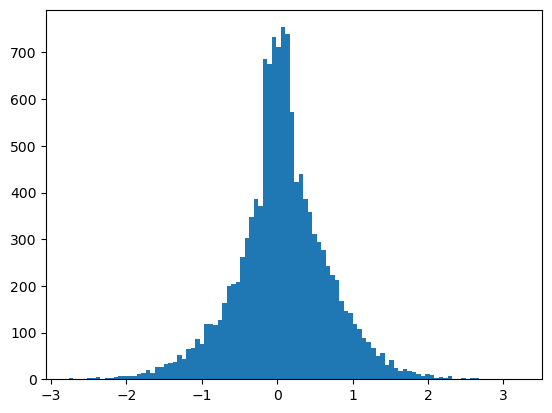

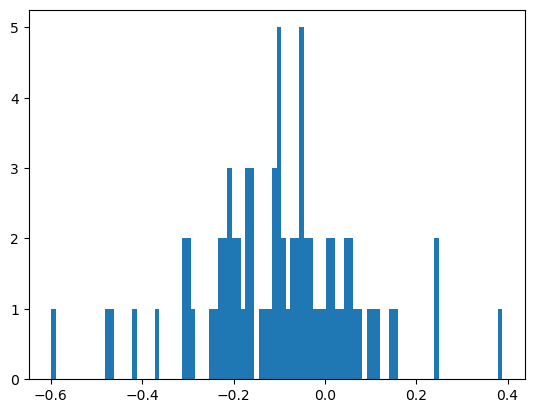

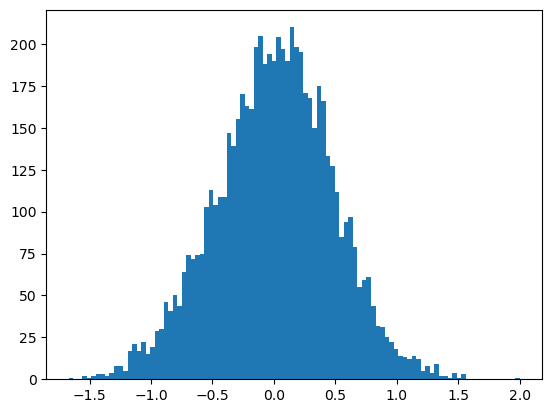

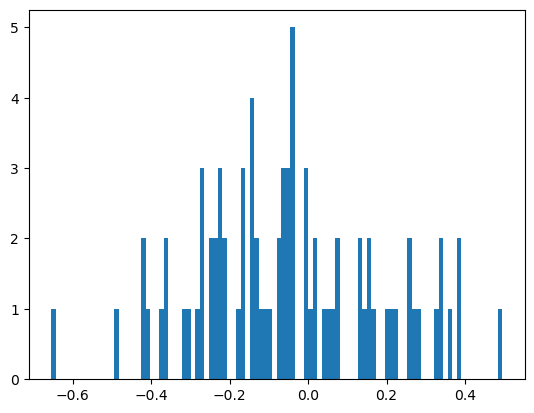

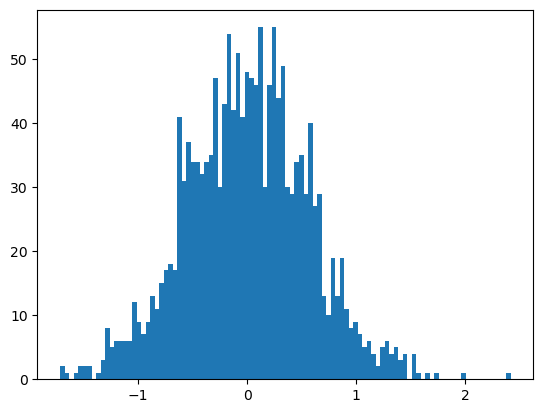

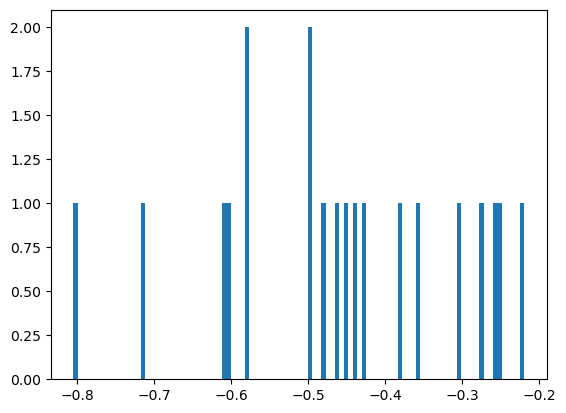

In [768]:
#print(numpy.mean(X_train,axis=0))
#print(list(model.parameters()))
for p in model.parameters():
    q=p.detach().numpy().flatten()
    print(q.size)
    plt.figure()
    plt.hist(q, bins=100)

In [672]:
for var_name in model.state_dict():
    print(var_name, "\t", model.state_dict()[var_name].shape)

hidden1.weight 	 torch.Size([3220, 161])
hidden1.bias 	 torch.Size([3220])
hidden_last.weight 	 torch.Size([20, 3220])
hidden_last.bias 	 torch.Size([20])


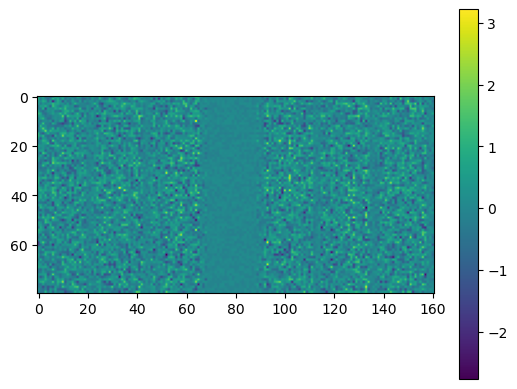

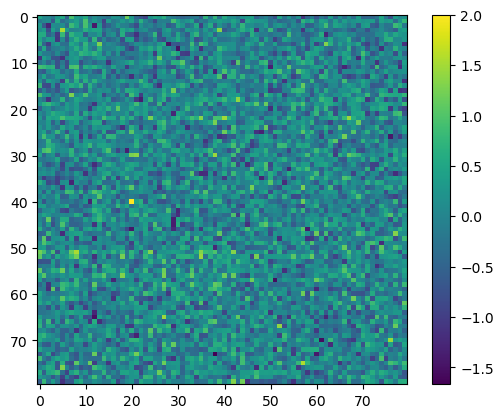

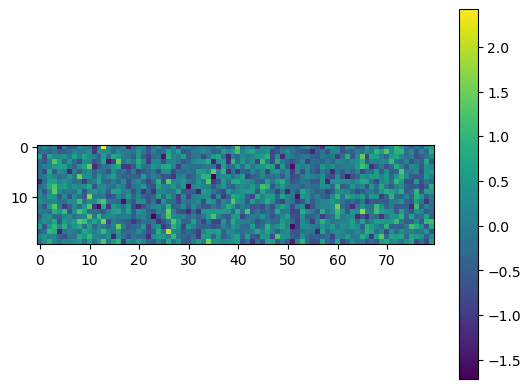

In [767]:
l1=model.hidden1.weight.detach().numpy()
plt.imshow(l1)
plt.colorbar()
l2=model.hidden2.weight.detach().numpy()
plt.figure()
plt.imshow(l2)
plt.colorbar()
l3=model.hidden_last.weight.detach().numpy()
plt.figure()
plt.imshow(l3)
plt.colorbar()
